In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import numpy as np, cv2
import os, glob, shutil, hashlib

# --- Preprocessing ---
def preprocess_image_file(path):
    img = load_image(path)
    img = autocrop_black(img)
    img = circular_crop(img)
    img = cv2.resize(img, TARGET_SIZE)
    img = img.astype('float32')
    img = preprocess_input(img)  # ✅ EfficientNet preprocessing
    return img

TARGET_SIZE = (224, 224)   # width, height for EfficientNet / CNN
NUM_CLASSES = 5            # since you have 5 DR categories

DATASET_ROOT = "/kaggle/input/aptos-augmented-images"
STANDARD_ROOT = os.path.join(DATASET_ROOT, 'aptos-augmented-images')
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# --- Preprocessing helpers ---
def autocrop_black(img, tol=7):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    if not mask.any():
        return img  # return original instead of empty
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    return img[y0:y1+1, x0:x1+1]

def circular_crop(img):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    mask = (X - center[0]) ** 2 + (Y - center[1]) ** 2 <= radius ** 2
    out = img.copy()
    out[~mask] = 0
    return out
X = np.array([preprocess_image_file(p) for p in files])
y = np.array(labels)

class_map = {
    "0": 0, # No DR
    "1": 1, # Mild
    "2": 2, # Moderate
    "3": 3, # Severe
    "4": 4  # Proliferative DR
}
def make_file_list_and_labels(root_dir):
    classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    files, labels = [], []
    for c in classes:
        c_clean = c.strip()
        if c_clean in class_map:
            class_label = class_map[c_clean]
            for p in glob.glob(os.path.join(root_dir, c, '*')):
                if p.lower().endswith(('.png', '.jpg', '.jpeg')):
                    files.append(p)
                    labels.append(class_label)
        else:
            print(f"Skipping unknown folder: '{c}'")

    if len(files) != len(labels):
        raise ValueError("Mismatch between number of files and labels!")
        
    return files, labels, classes

# Load dataset
files, labels, classes = make_file_list_and_labels(STANDARD_ROOT)
print(f"Found {len(files)} images across {len(classes)} classes.")

X = np.array([preprocess_image_file(p) for p in files])
y = np.array(labels)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Training:", X_train.shape, "| Validation:", X_val.shape)

# --- Base Model (Transfer Learning) ---
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)
base_model.trainable = False  # ✅ Freeze for initial training

# --- Classifier Head ---
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

# --- Compile ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Train ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# --- Fine-tune (Optional) ---
base_model.trainable = True  # unfreeze
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)

# --- Evaluate ---
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"\n✅ Final Validation Accuracy: {val_acc*100:.2f}% | Validation Loss: {val_loss:.4f}")


Skipping unknown folder: 'aptos-augmented-images'
Found 10000 images across 6 classes.
Training: (8000, 224, 224, 3) | Validation: (2000, 224, 224, 3)


I0000 00:00:1759712129.193609      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10


I0000 00:00:1759712156.689094      97 service.cc:148] XLA service 0x7b773c004090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759712156.689633      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759712158.346874      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/250 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.2477 - loss: 1.7526   

I0000 00:00:1759712167.247911      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - accuracy: 0.2691 - loss: 1.6353 - val_accuracy: 0.4790 - val_loss: 1.3189
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4506 - loss: 1.3087 - val_accuracy: 0.5575 - val_loss: 1.1691
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.5110 - loss: 1.1835 - val_accuracy: 0.5735 - val_loss: 1.0919
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5458 - loss: 1.1050 - val_accuracy: 0.5865 - val_loss: 1.0418
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5550 - loss: 1.0650 - val_accuracy: 0.5975 - val_loss: 1.0069
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5774 - loss: 1.0211 - val_accuracy: 0.6015 - val_loss: 0.9823
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5938 - loss: 0.9882 - val_accuracy: 0.6065 - val_loss: 0.9636
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5906 - loss: 0.9853 - val_accuracy:

E0000 00:00:1759712347.599976      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759712347.787421      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759712348.259083      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759712348.466297      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759712348.828660      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

250/250 ━━━━━━━━━━━━━━━━━━━━ 120s 160ms/step - accuracy: 0.4577 - loss: 1.2486 - val_accuracy: 0.5810 - val_loss: 1.0093
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.5563 - loss: 1.0509 - val_accuracy: 0.6180 - val_loss: 0.9541
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.6132 - loss: 0.9492 - val_accuracy: 0.6375 - val_loss: 0.9044
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.6461 - loss: 0.8753 - val_accuracy: 0.6450 - val_loss: 0.8715
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.6542 - loss: 0.8464 - val_accuracy: 0.6525 - val_loss: 0.8420
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6706 - loss: 0.8011

✅ Final Validation Accuracy: 65.25% | Validation Loss: 0.8420


Skipping unknown folder: 'aptos-augmented-images'

✅ Found 10000 images across 6 classes.
Classes found: ['aptos-augmented-images', '2', '0', '3', '1', '4']
Unique labels: {0, 1, 2, 3, 4}
Class 2: 2000 images
Class 0: 2000 images
Class 3: 2000 images
Class 1: 2000 images
Class 4: 2000 images


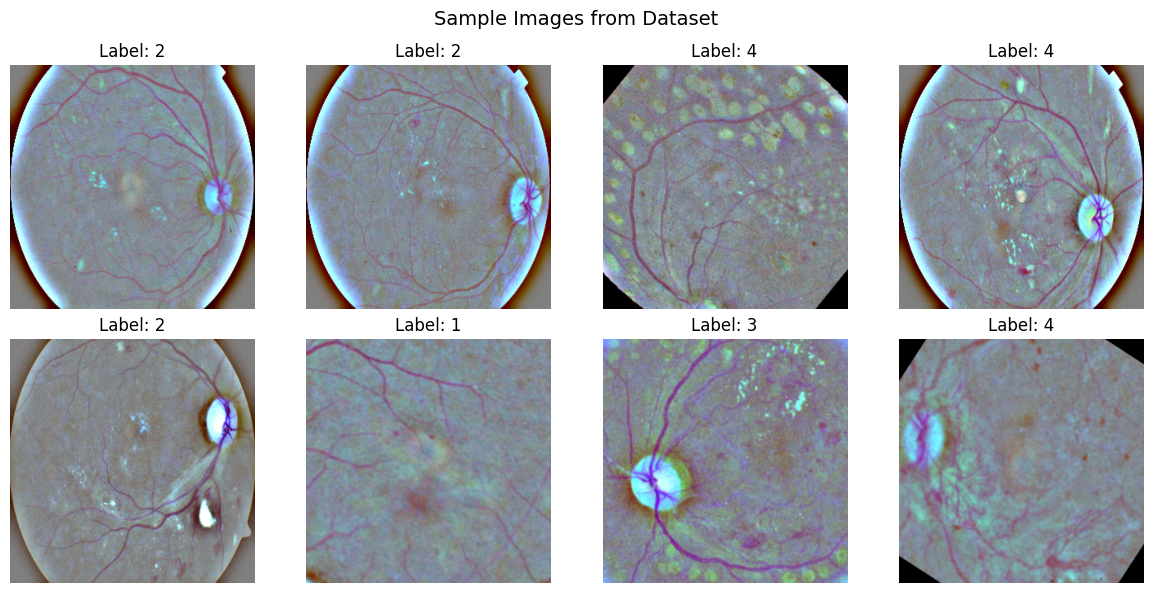

In [11]:
import matplotlib.pyplot as plt
import random

# Load dataset
files, labels, classes = make_file_list_and_labels(STANDARD_ROOT)
print(f"\n✅ Found {len(files)} images across {len(classes)} classes.")
print(f"Classes found: {classes}")
print(f"Unique labels: {set(labels)}")

# Quick sanity check on class distribution
from collections import Counter
label_counts = Counter(labels)
for lbl, count in label_counts.items():
    print(f"Class {lbl}: {count} images")

# --- Display few random samples ---
plt.figure(figsize=(12, 6))
for i in range(8):
    idx = random.randint(0, len(files) - 1)
    img = load_image(files[idx])
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')
plt.suptitle("Sample Images from Dataset", fontsize=14)
plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


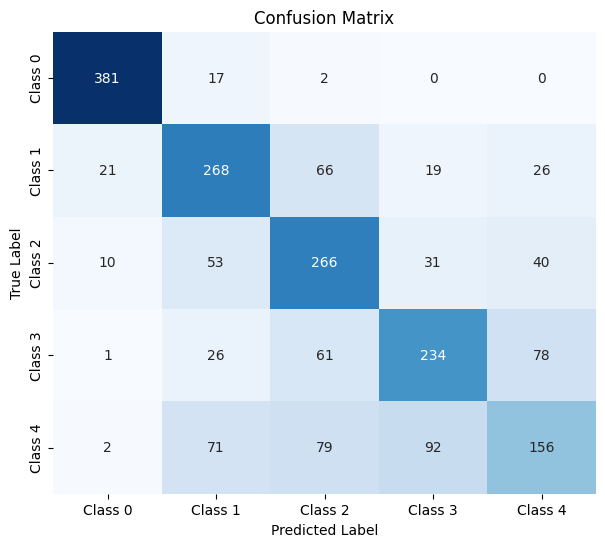

📋 Classification Report:

              precision    recall  f1-score   support

     Class 0       0.92      0.95      0.93       400
     Class 1       0.62      0.67      0.64       400
     Class 2       0.56      0.67      0.61       400
     Class 3       0.62      0.58      0.60       400
     Class 4       0.52      0.39      0.45       400

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# --- Compute unique labels ---
unique_labels = sorted(list(set(y_val)))  # ensures labels like [0,1,2,3,4]

# --- Confusion Matrix ---
y_pred = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, y_pred, labels=unique_labels)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f"Class {i}" for i in unique_labels],
            yticklabels=[f"Class {i}" for i in unique_labels])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Classification Report ---
report = classification_report(
    y_val,
    y_pred,
    labels=unique_labels,
    target_names=[f"Class {i}" for i in unique_labels]
)
print("📋 Classification Report:\n")
print(report)
